In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

import torchvision.transforms as T

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
def decode_segmap(image, source, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)


  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)

  foreground = cv2.imread(source)


  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
  
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  
  foreground = foreground.astype(float)
  background = background.astype(float)

  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  alpha = alpha.astype(float)/255

  foreground = cv2.multiply(alpha, foreground)  

  background = cv2.multiply(1.0 - alpha, background)  

  outImage = cv2.add(foreground, background)

  return outImage/255

In [4]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

  rgb = decode_segmap(om, path)

  plt.imshow(rgb); plt.axis('off'); plt.show()




Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


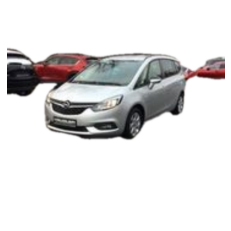

In [5]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

segment(dlab, '/content/drive/My Drive/Y_axFYzQ.jpeg', show_orig=False) 

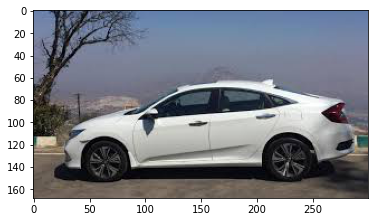

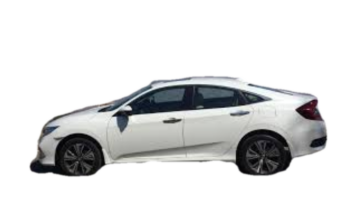

In [6]:
img = Image.open('/content/drive/My Drive/images (1).jpeg')
plt.imshow(img); plt.show()
segment(dlab, '/content/drive/My Drive/images (1).jpeg', show_orig=False)

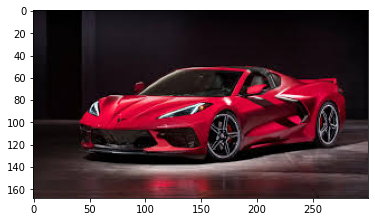

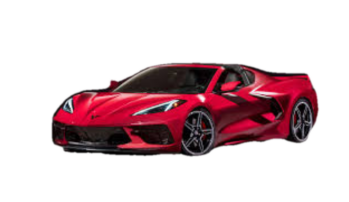

In [8]:
img = Image.open('/content/drive/My Drive/download.jpeg')
plt.imshow(img); plt.show()
segment(dlab, '/content/drive/My Drive/download.jpeg', show_orig=False)